In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

##questions we need to index...
    ##FR_native = BINARY (0, 1) based on q2_a_2lang_1 (1st input to Q: "list languages by order acq", q1_a_1lang for monolinguals)
    ##AoA_L1_years = 1_q8_b_*lang_1 (L2 = 1_q8_b_*lang_2...) q3_b_1lang_1
    ##Pro_L1_scale10 = AVERAGE(1_q10_b_*lang_1 + 2_q10_b_*lang_1 + 3_q10_b_*lang_1)
    
# the LEAPQ variables are written like 2_q8_b_3lang_1, where:
    ##2 = the language code (2=L2, 3=L3... there is no initial number for monolinguals, see below)
    ##q8 = the question number
    ##b = indicates it's a part of the qualtrics loop for each lang (i.e., multilingual Q)
    ##3lang = indicates the number of languages (& length of survey) for that subject
    ##1 = indicates the number for that question within its subgroup (there may be multiple subquestions/scores per Q, e.g., scale ratings across reading, writing)

In [2]:
# load LEAPQ file
df = pd.read_excel('LEAPQ_3Oct23_working.xlsx', sheet_name = "final_cleaned")
df['nlang'] = pd.to_numeric(df['nlang'], errors='coerce') #code nlang column as numeric
df['nlang'] = df['nlang'].astype('Int64') #remove decimal

################### preprocess ###################
# change commas (1,5) to decimal points (1.5)
#df.iloc[1:] = df.iloc[1:].replace(',', '.', regex=True).apply(pd.to_numeric)
# replace strings "parfait (10)" etc with their numeric value
df = df.replace("parfait (10)", "10")
df = df.replace("Parfait", "10")
df = df.replace("toujours (10)", "10")
df = df.replace("contributeur le plus important (10)", "10")
df = df.replace("contributeur mod√©r√© (5)", "5")
df = df.replace("la moiti√© du temps (5)", "5")
df = df.replace("pas un contributeur (0)", "0")
df = df.replace("jamais (0)", "0")
df = df.replace("Aucun (0)", "0")
df = df.replace("Non applicable", "")
#Omnipr√©sent (10)
#Mod√©r√© (5)
#Aucun (0)
#Toujours pas --> deleted (manual entry for 2 participants... "age when you...")
#Pas encore --> deleted (manual entry for 2 participants "age when you...")
#"Non-applicable" = empty

In [3]:
################### define function for extracting language names ###################
# dictionary to store results for all language names per row (subject)
all_langs = {}  

def extract_language_names(row):
    nlang = row['nlang']
    
    # monolinguals have a different question number than multilinguals
    if nlang == 1:
        lang_names = [row["q1_a_1lang"]]
    else:
        lang_names = []
        for nlang_level in range(2, nlang + 1):
            lang_col = f"q2_a_{nlang_level}lang"
            lang_names.extend(df.loc[row.name, [f"{lang_col}_{i}" for i in range(1, nlang_level + 1)]].dropna().tolist())
    
    all_langs[row.name] = lang_names
    return lang_names

def get_native_status(row):
    lang_names = row['all_languages']
    
    if lang_names:
        # Check if the first language in the list contains "francais"
        return 1 if re.search(r'fran[a-zA-Z]*', lang_names[0].lower()) else 0
    else:
        return 0  # Handle the case where the list is empty, assuming non-native

In [4]:
################### define AoA function ###################
all_AoAs = {}  # Dictionary to store results for each language
def compute_AoA_average(row):
    nlang = row['nlang']

    # monolinguals have a different question number than multilinguals
    if nlang == 1:
        avg_columns = [f"q3_b_{row['nlang']}lang_{i}" for i in range(1, 3)] #including (3) reading?
        avg_values = pd.to_numeric(df.loc[row.name, avg_columns], errors='coerce')
        return avg_values.mean()

    # sort the multilinguals based on their # of langs (nlang)
    language_results = {}
    for lang in range(1, nlang + 1):
        avg_columns = f"{lang}_q8_b_{row['nlang']}lang"
        avg_values = pd.to_numeric(df.loc[row.name, [f"{avg_columns}_{i}" for i in range(1, 3)]], errors='coerce')
        language_results[f'L{lang}_AoA'] = avg_values.mean()

    all_AoAs[row.name] = language_results
    return sum(language_results.values()) / nlang

################### define proficiency function ###################
all_profs = {}  # Dictionary to store results for each language
def compute_profscale_average(row):
    nlang = row['nlang']

    # monolinguals have a different question number than multilinguals
    if nlang == 1:
        avg_columns = [f"q5_b_{row['nlang']}lang_{i}" for i in range(1, 4)]
        avg_values = pd.to_numeric(df.loc[row.name, avg_columns], errors='coerce')
        return avg_values.mean()

    # sort the multilinguals based on their # of langs (nlang)
    proficiency_results = {}
    for lang in range(1, nlang + 1):
        avg_columns = f"{lang}_q10_b_{row['nlang']}lang"
        avg_values = pd.to_numeric(df.loc[row.name, [f"{avg_columns}_{i}" for i in range(1, 4)]], errors='coerce')
        proficiency_results[f'L{lang}_proficiency'] = avg_values.mean()

    all_profs[row.name] = proficiency_results
    return sum(proficiency_results.values()) / nlang

In [5]:
################### apply functions ###################
# extract language names
df['all_languages'] = df.apply(extract_language_names, axis=1)

# MUTLILINGUAL? (0=monolingual; 1=multilingual)
df['multilingual'] = np.where(df['nlang'] == 1, 0, 1)
multicheck = df['multilingual'].value_counts()
n = len(df['multilingual'])
print(f"There are {multicheck[0]} monolinguals and {multicheck[1]} multilinguals for a total of {n} subjects.")

# NATIVE LANGUAGE ?
df['FR_native'] = df.apply(get_native_status, axis=1)
native_check = df['FR_native'].value_counts()
print(f"There are {native_check[1]} french native subjects and {native_check[0]} non-native subjects.")

# AOA ? (average across age of original acq, age of fluent speaking, age of fluent reading)
df['average_AoA'] = df.apply(compute_AoA_average, axis=1)
all_AoAs_df = pd.DataFrame(all_AoAs).transpose()
#print(all_AoAs_df)

# PROFICIENCY ? (average across 3 scores based on scale 1-10)
df['average_proficiency'] = df.apply(compute_profscale_average, axis=1)
all_profs_df = pd.DataFrame(all_profs).transpose()
#print(all_profs_df)

################### create new, preprocessed & clean dataframe with key variables of interest ###################

# combine output
combined_df = pd.concat([df, all_AoAs_df, all_profs_df], axis=1)

# save it to a file along with original columns from the LEAPQ output (we calculated the variable AGE_YEARS in the excel since subs gave 2 answers
# for "age" - one answer for the # years and another for the additional months (e.g., 27 years, 2 months)
columns_to_keep = ['ID', 'AGE_YEARS', 'AGE_MONTHS', 'nlang', 'multilingual', 'FR_native', 'all_languages'] + list(all_AoAs_df.columns) + list(all_profs_df.columns)
result_df = combined_df[columns_to_keep]
result_df.to_csv('allsubs_leapq_preproc.csv', index=False)

There are 5 monolinguals and 61 multilinguals for a total of 66 subjects.
There are 38 french native subjects and 28 non-native subjects.


In [6]:
################### generate summary stats ###################
# filter df based on group_condition (here # languages, nlang)
#group_condition = result_df['nlang'] == 3  # Look based on # of languages
group_condition = result_df['multilingual'] == 1  # Look based on native language

group_df = result_df[group_condition]

# drop empty columns (e.g., L3_AoA for someone with nlang=2)
group_df = group_df.dropna(axis=1, how='all')

# summary stats
summary_stats = group_df.describe()
print(f"Summary statistics for continuous measures in the specified group:")
print(summary_stats)

#check L2_AoA, L3_AoA, ..., for the non-natives (is below 7?) - manual editing in excel
fr_nonnative = result_df[df['multilingual'] == 1]
fr_nonnative.to_csv('multilingual_speakers_checkAoA.csv', index=False)

Summary statistics for continuous measures in the specified group:
       AGE_YEARS  AGE_MONTHS     nlang  multilingual  FR_native    L1_AoA   
count  61.000000   61.000000      61.0          61.0  61.000000  61.00000  \
mean   22.445355  269.344262  4.213115           1.0   0.540984   3.30000   
std     3.976548   47.718580  1.603275           0.0   0.502453   3.60088   
min    18.166667  218.000000       2.0           1.0   0.000000   0.00000   
25%    20.500000  246.000000       3.0           1.0   0.000000   1.50000   
50%    21.500000  258.000000       4.0           1.0   1.000000   2.25000   
75%    22.666667  272.000000       5.0           1.0   1.000000   3.25000   
max    41.333333  496.000000       9.0           1.0   1.000000  20.00000   

          L2_AoA     L3_AoA     L4_AoA     L5_AoA  ...  L9_AoA   
count  61.000000  52.000000  39.000000  23.000000  ...     1.0  \
mean    9.327869   9.954808  11.407692  11.623913  ...    13.0   
std     6.691839   4.790833   4.358047   

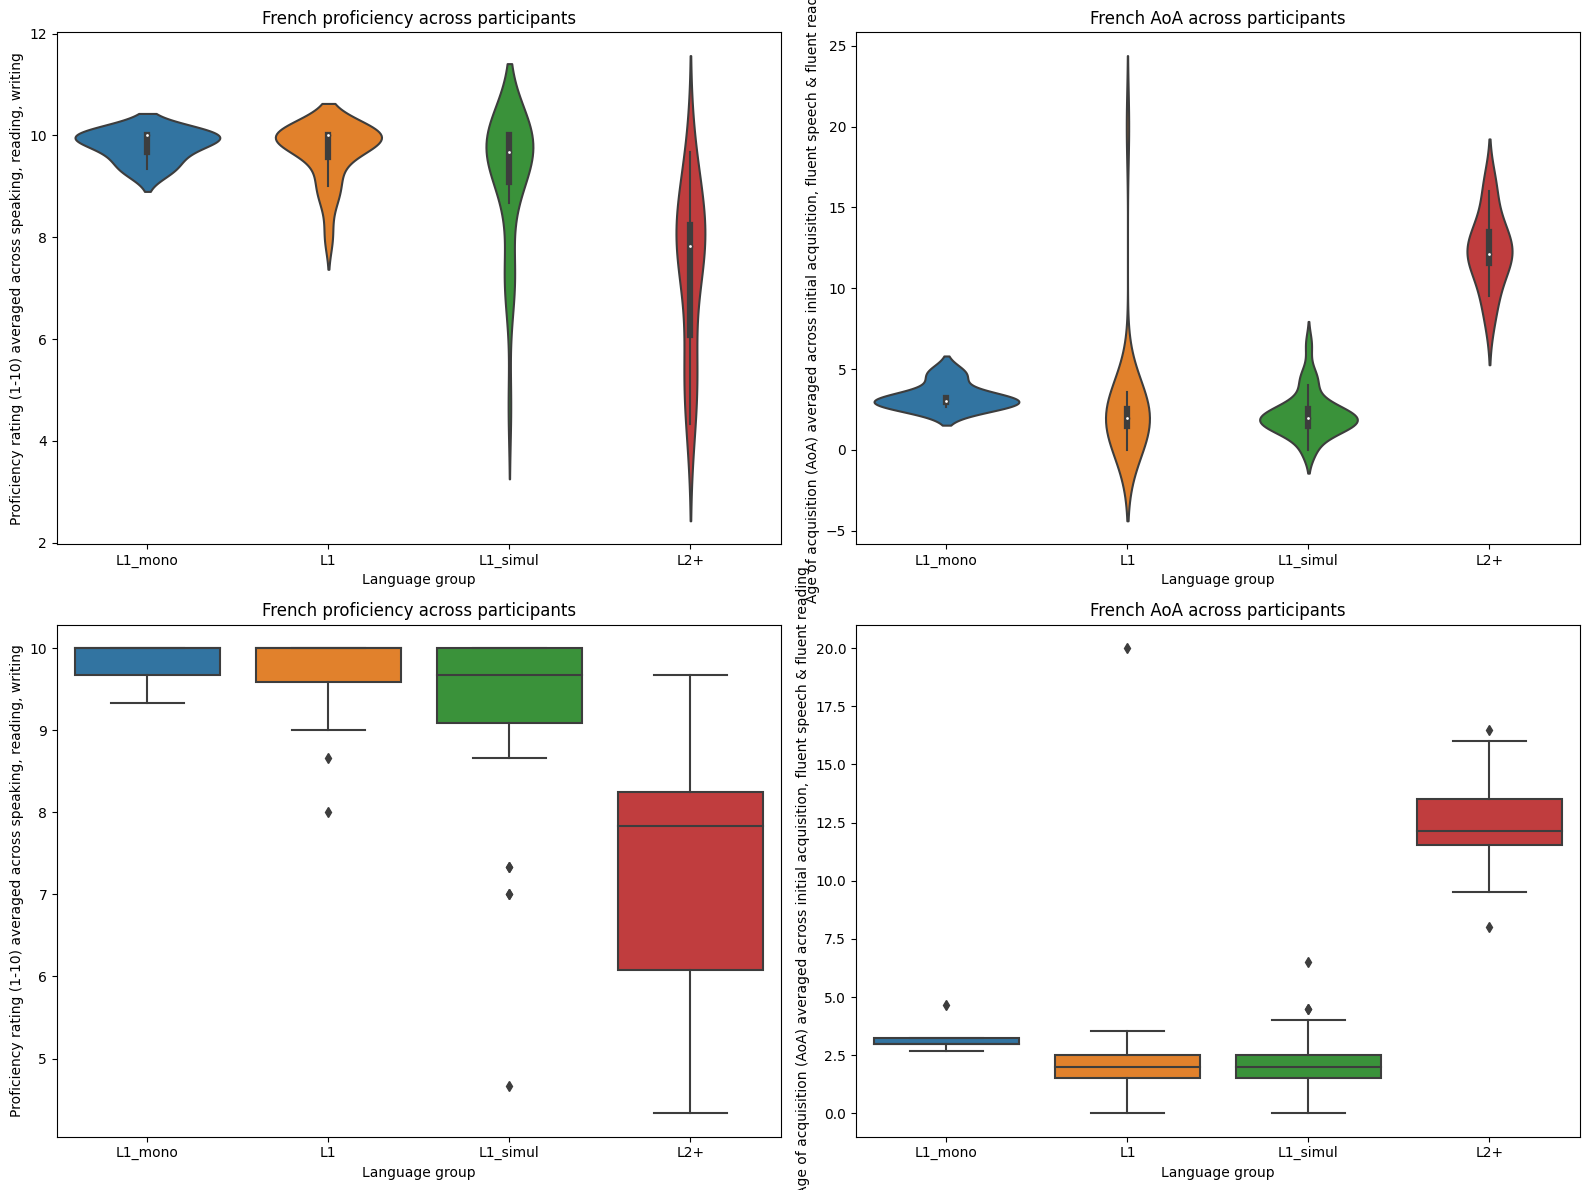

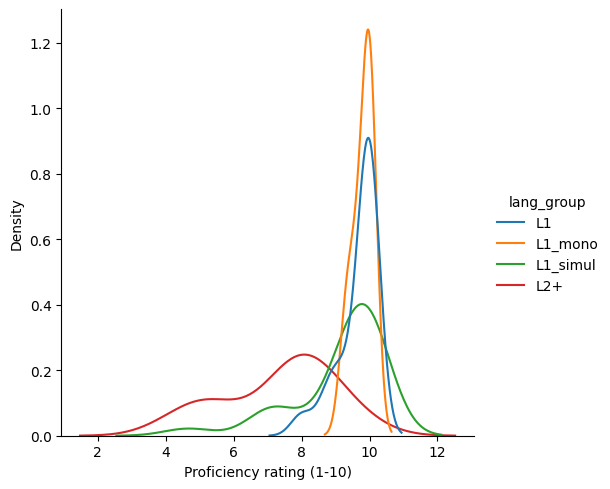

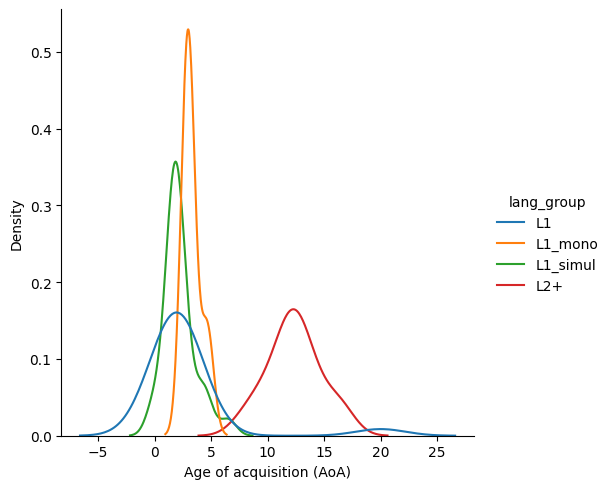

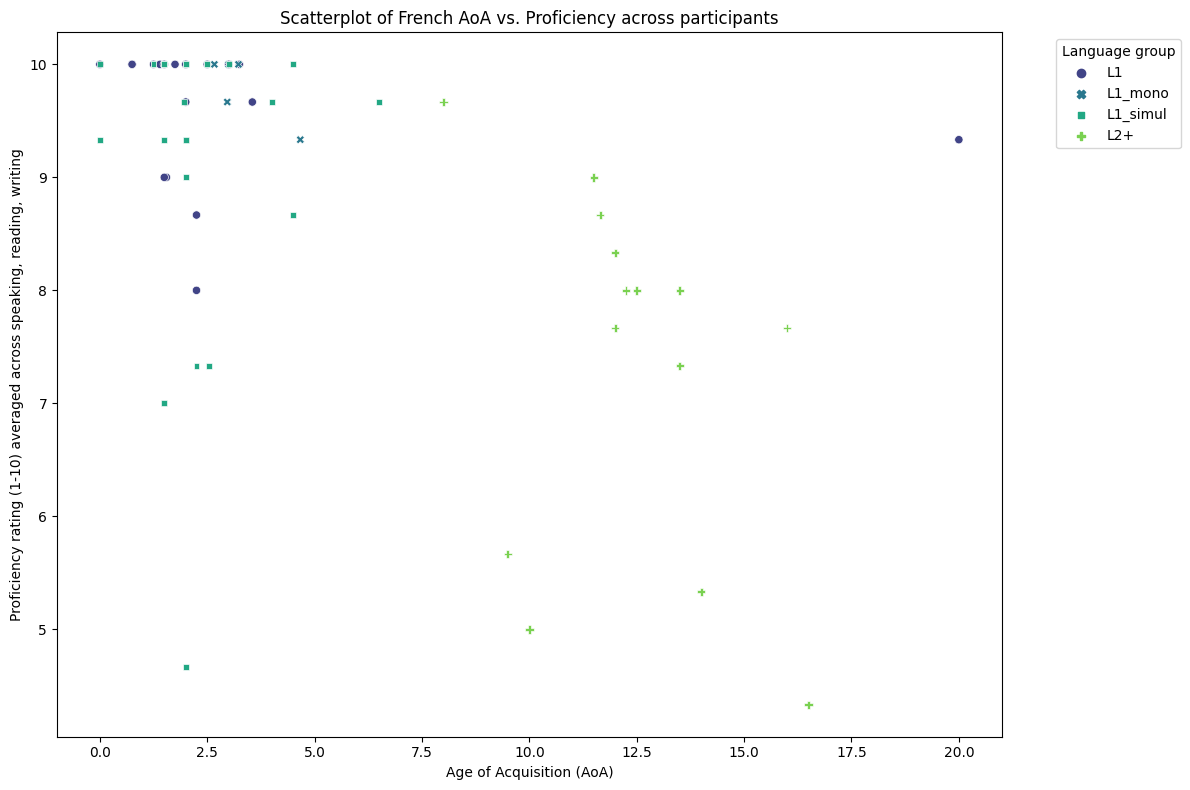

In [9]:
################### plotting ###################
from scipy.stats import f_oneway  # Import the ANOVA function


#using a different excel sheet now since we did manual corrections from previous output 'multilingual_speakers_checkAoA.csv'
def create_and_save_plots(data_file='all_subs_working.xlsx', save_prefix='plot'):
    
    # load manually checked & edited excel file with new columns
    cleaned_df = pd.read_excel(data_file, sheet_name="all_subjects")

    # there are now 4 groups under column "lang_group":
    # French native monolingual (L1_mono)
    # French native multilingual (L1)
    # French native simultaneous multilingual (L1_simul)
    # French non-native multilingual (L2+)

    # set the order of groups for visualization
    group_order = ['L1_mono', 'L1', 'L1_simul', 'L2+'] #for group/xvar of "lang_group"
    #group_order = [0, 1] #for group/xvar of "FR_native2_under7yearsFR_AoA" or FR_native

    ################### violin plots ###################
    # set up subplots for the 4x4 grid image created from boxplots & violin plots
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

    # violin plots for french proficiency across groups
    sns.violinplot(x='lang_group', y='FR_prof', data=cleaned_df, order=group_order, ax=axes[0, 0])
    axes[0, 0].set_xlabel('Language group')
    axes[0, 0].set_ylabel('Proficiency rating (1-10) averaged across speaking, reading, writing')
    axes[0, 0].set_title('French proficiency across participants')

    # violin plots for french AoA across groups
    sns.violinplot(x='lang_group', y='FR_AoA', data=cleaned_df, order=group_order, ax=axes[0, 1])
    axes[0, 1].set_xlabel('Language group')
    axes[0, 1].set_ylabel('Age of acquisition (AoA) averaged across initial acquisition, fluent speech & fluent reading')
    axes[0, 1].set_title('French AoA across participants')

    ################### boxplots ###################
    # boxplot for french proficiency across groups
    sns.boxplot(x='lang_group', y='FR_prof', data=cleaned_df, order=group_order, ax=axes[1, 0])
    axes[1, 0].set_xlabel('Language group')
    axes[1, 0].set_ylabel('Proficiency rating (1-10) averaged across speaking, reading, writing')
    axes[1, 0].set_title('French proficiency across participants')

    # boxplot for french AoA across groups
    sns.boxplot(x='lang_group', y='FR_AoA', data=cleaned_df, order=group_order, ax=axes[1, 1])
    axes[1, 1].set_xlabel('Language group')
    axes[1, 1].set_ylabel('Age of acquisition (AoA) averaged across initial acquisition, fluent speech & fluent reading')
    axes[1, 1].set_title('French AoA across participants')

    # adjust layout & save
    plt.tight_layout()
    plt.savefig(f'{save_prefix}_combined_plots.png')

    # show the plot
    plt.show()

    ################### KDE plots ###################

    # KDE plot for French proficiency across groups
    sns.displot(cleaned_df, x="FR_prof", kind="kde", hue="lang_group", common_norm=False)
    plt.xlabel('Proficiency rating (1-10)')
    #plt.title('Kernel Density Estimate (KDE) plot for French proficiency across language groups')
    plt.savefig(f'{save_prefix}_KDE_french_proficiency.png')  # Save the plot

    # KDE plot for French AoA across groups
    sns.displot(cleaned_df, x="FR_AoA", kind="kde", hue="lang_group", common_norm=False)
    plt.xlabel('Age of acquisition (AoA)')
    #plt.title('Kernel Density Estimate (KDE) plot for French AoA across language groups')
    plt.savefig(f'{save_prefix}_KDE_french_AoA.png')  # Save the plot

    # Show the plots
    plt.show()

    ################### scatterplot ###################

    # scatterplot for french proficiency & AoA across groups
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='FR_AoA', y='FR_prof', hue='lang_group', data=cleaned_df, palette='viridis', style='lang_group',
                    markers=True)
    plt.xlabel('Age of Acquisition (AoA)')
    plt.ylabel('Proficiency rating (1-10) averaged across speaking, reading, writing')
    plt.title('Scatterplot of French AoA vs. Proficiency across participants')
    plt.legend(title='Language group', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(f'{save_prefix}_scatterplot_french_AoA_proficiency.png')  # Save the plot

    plt.show()

#function call    
create_and_save_plots()
